In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
filename = "email-Eu-core-temporal-Dept3.txt"

In [3]:
import pyspark
import itertools
import pyspark
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import Window 
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.mllib.linalg.distributed import IndexedRow, IndexedRowMatrix
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read data

In [4]:
conf = SparkConf().setMaster("local").setAppName("My App")
sc = SparkContext(conf = conf)

# create a spark session
spark = SparkSession.builder.appName('link-prediction').getOrCreate()

In [5]:
# read data as list
with open(filename) as csvfile:
    data = [list(map(int, row)) for row in csv.reader(csvfile, delimiter=' ')]

# make a spark dataframe
columns = ["u", "v", "t"]
df = spark.createDataFrame(data=data, schema=columns)

df.toPandas()

,u,v,t
0,11,39,0
1,48,54,2635
2,69,60,4249
3,69,60,13362
4,33,84,16943
...,...,...,...
12211,26,46,45301515
12212,46,26,45301553
12213,16,73,45304269
12214,30,60,45305184


# Select based on timeframe

In [6]:
train_df = df.filter(F.col("t") < 20_000_000)
test_df = df.filter(F.col("t") >= 20_000_000).filter(F.col("t") < 22_000_000)

train_df.toPandas(), test_df.toPandas()

(       u   v         t
 0     11  39         0
 1     48  54      2635
 2     69  60      4249
 3     69  60     13362
 4     33  84     16943
 ...   ..  ..       ...
 5152  23  88  19987782
 5153  87  56  19988698
 5154  43  67  19989289
 5155  16  15  19989592
 5156  64  85  19993413
 
 [5157 rows x 3 columns],
       u   v         t
 0    54  49  20045846
 1    54  63  20045902
 2    67  43  20049149
 3    87  56  20051568
 4     2  24  20051831
 ..   ..  ..       ...
 653  60  16  21899410
 654  60  67  21899410
 655  60  54  21899410
 656  60  52  21899410
 657  60  15  21899410
 
 [658 rows x 3 columns])

In [7]:
nodes = train_df\
  .select("u")\
  .union(train_df.select("v"))\
  .withColumnRenamed("u", "node")\
  .distinct().orderBy("node")

all_node_pairs = nodes.withColumnRenamed("node", "u")\
  .join(nodes.withColumnRenamed("node", "v"))
  
num_nodes = nodes.count()

nodes.toPandas()

,node
0,0
1,1
2,2
3,3
4,4
...,...
75,85
76,86
77,87
78,88


## SimRank

In [8]:
gamma = train_df\
    .select(F.col("u").alias("v"), F.col("v").alias("u"))\
    .union(train_df.select(F.col("u"), F.col("v")))\
    .groupby("u")\
    .agg(F.collect_list("v").alias("edges"))\
    .select(F.col("u").alias("node"), F.array_distinct("edges").alias("gamma"), F.size(F.col("edges")).alias("degree"))\
    .select("node", "gamma", F.size("gamma").alias("gamma_size"), "degree")\
    .filter(F.size("gamma") > 2)

gamma.toPandas()

,node,gamma,gamma_size,degree
0,26,"[57, 51, 24, 18, 65, 35, 37, 33, 25, 46, 4, 39...",13,292
1,29,"[49, 61, 60, 85, 62, 22, 23]",7,38
2,65,"[57, 54, 24, 85, 46, 48, 26, 32, 2, 67, 52, 17...",17,188
3,54,"[48, 22, 65, 39, 24, 84, 60, 49, 63, 88, 52, 6...",24,532
4,19,"[85, 64, 70, 35, 83, 25, 67, 16, 1, 9, 88]",11,204
...,...,...,...,...
69,60,"[69, 16, 29, 23, 49, 88, 14, 25, 43, 21, 66, 7...",33,470
70,16,"[60, 54, 49, 25, 4, 32, 88, 64, 85, 35, 9, 61,...",17,290
71,64,"[39, 85, 19, 1, 83, 16, 58, 4, 49, 55, 25, 35,...",14,146
72,53,"[38, 18, 4, 37, 54, 85, 49, 60, 26]",9,38


In [45]:
k = 0.8
iterations = 5

In [46]:
A_adj_neighbours = gamma.select(F.col('node').alias('u'), F.explode('gamma').alias('v'))
A_adj = A_adj_neighbours.join(gamma, (A_adj_neighbours.v==gamma.node), 'left').select(A_adj_neighbours.u, A_adj_neighbours.v, gamma.gamma_size)

A_adj = all_node_pairs.join(A_adj, (A_adj.u==all_node_pairs.u) & (A_adj.v==all_node_pairs.v), 'left')\
                  .select(all_node_pairs.u, all_node_pairs.v, (1/F.col('gamma_size')).alias('value')).fillna(0).fillna("0")\
                  .orderBy('u', 'v')
A_adj.toPandas()

,u,v,value
0,0,0,0.0
1,0,1,0.0
2,0,2,0.0
3,0,3,0.0
4,0,4,0.0
...,...,...,...
6395,89,85,0.0
6396,89,86,0.0
6397,89,87,0.0
6398,89,88,0.0


In [47]:
simrank_adj = all_node_pairs.select('u', 'v', F.when(F.col('u') == F.col('v'), 1)\
  .otherwise(0).alias('simrank'))\
  .orderBy('u','v')

simrank_adj.toPandas()

,u,v,simrank
0,0,0,1
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0
...,...,...,...
6395,89,85,0
6396,89,86,0
6397,89,87,0
6398,89,88,0


In [48]:
A_w = Window.partitionBy("u").orderBy("v")

A = A_adj\
  .withColumn("sorted_list", F.collect_list("value").over(A_w))\
  .groupBy("u")\
  .agg(F.max("sorted_list").alias('row'))\
  .orderBy('u')\
  .withColumn("id", F.monotonically_increasing_id())
  
A.toPandas()

,u,row,id
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,1,"[0.25, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0...",1
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
3,3,"[0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0,...",3
4,4,"[0.0, 0.05263157894736842, 0.0, 0.2, 0.0, 0.0,...",4
...,...,...,...
75,85,"[0.0, 0.05263157894736842, 0.0, 0.0, 0.04, 0.0...",75
76,86,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",76
77,87,"[0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0,...",77
78,88,"[0.0, 0.05263157894736842, 0.16666666666666666...",78


In [49]:
simrank_w = Window.partitionBy("u").orderBy("v")

simrank = simrank_adj\
  .withColumn("sorted_list", F.collect_list("simrank").over(simrank_w))\
  .groupBy("u")\
  .agg(F.max("sorted_list").alias('row'))\
  .orderBy('u')\
  .withColumn("id", F.monotonically_increasing_id())
  
simrank.toPandas()

,u,row,id
0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
2,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2
3,3,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
4,4,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4
...,...,...,...
75,85,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",75
76,86,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",76
77,87,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",77
78,88,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",78


In [50]:
A_matrix = IndexedRowMatrix(A.select("id", "row").rdd.map(lambda row: IndexedRow(*row)))\
  .toBlockMatrix(num_nodes, num_nodes)

simrank_matrix = IndexedRowMatrix(simrank.select("id", "row").rdd.map(lambda row: IndexedRow(*row)))\
  .toBlockMatrix(num_nodes, num_nodes)

c_np = k*np.eye(num_nodes)
C = IndexedRowMatrix(sc.parallelize([IndexedRow(i, c_np[i]) for i in range(num_nodes)]))\
  .toBlockMatrix(num_nodes, num_nodes)

In [51]:
for i in range(iterations):
  simrank_matrix = C.multiply(A_matrix.transpose().multiply(simrank_matrix).multiply(A_matrix))

In [52]:
schema = T.StructType([
    T.StructField('Id', T.IntegerType(), True),
    T.StructField('row', T.ArrayType(T.FloatType()), True)
])
simrank = spark.createDataFrame(simrank_matrix.toIndexedRowMatrix().rows.map(lambda ele: (ele.index, ele.vector.toArray().tolist())),\
                                schema)

In [53]:
simrank_scores = simrank.join(A, (simrank.Id == A.id)).select(A.u, simrank.row)\
                  .select('u', F.posexplode_outer("row")).withColumnsRenamed({'u':'node1', 'pos':'vid','col':'simrank'})

simrank_scores = simrank_scores.join(A, (simrank_scores.vid == A.id))\
                  .select(simrank_scores.node1, A.u.alias('node2'), simrank_scores.simrank)\
                  .select(F.concat(F.col("node1"), F.lit(","), F.col("node2")).alias("u,v"), 'simrank')

simrank_scores.toPandas()

,"u,v",simrank
0,"0,0",0.011408
1,"0,1",0.006298
2,"0,2",0.013771
3,"0,3",0.005322
4,"0,4",0.009809
...,...,...
6395,"89,85",0.000000
6396,"89,86",0.000000
6397,"89,87",0.000000
6398,"89,88",0.000000


## Katz

In [18]:
edges = train_df\
  .drop("t")\
  .groupby("u", "v")\
  .count()

maxCount = edges\
  .select(
      F.max(edges["count"]).alias("maxCount")
  ).collect()[0]["maxCount"]

edges.orderBy("u", "v").toPandas()

,u,v,count
0,0,1,8
1,0,39,22
2,0,64,6
3,0,70,9
4,0,71,50
...,...,...,...
970,88,77,1
971,88,78,1
972,88,79,1
973,88,84,2


In [19]:
_katz_adj = nodes.withColumnRenamed("node", "_u")\
  .join(nodes.withColumnRenamed("node", "_v"))\
  .orderBy("_u", "_v")

beta = 1 / (1.5 * maxCount)

katz_edges = edges\
  .withColumn("value", edges["count"] * beta)\
  .drop("count")

katz_adj = _katz_adj\
  .join(
    katz_edges, 
    (_katz_adj._u == katz_edges.u)
      & (_katz_adj._v == katz_edges.v),
    'left'
  )\
  .select("_u", "_v", "value")\
  .fillna(0)\
  .withColumnRenamed("_u", "u")\
  .withColumnRenamed("_v", "v")

katz_adj.orderBy("u", "v").toPandas()

,u,v,value
0,0,0,0.000000
1,0,1,0.036782
2,0,2,0.000000
3,0,3,0.000000
4,0,4,0.000000
...,...,...,...
6395,89,85,0.000000
6396,89,86,0.000000
6397,89,87,0.000000
6398,89,88,0.000000


In [20]:
katz_w = Window.partitionBy("u").orderBy("v")
_katz_A = katz_adj\
  .withColumn("sorted_list", F.collect_list("value").over(katz_w))\
  .groupBy("u")\
  .agg(F.max("sorted_list").alias('row'))\
  .orderBy('u')\
  .withColumn("id", F.monotonically_increasing_id())
_katz_A.toPandas()

,u,row,id
0,0,"[0.0, 0.0367816091954023, 0.0, 0.0, 0.0, 0.0, ...",0
1,1,"[0.0, 0.0, 0.0, 0.0, 0.013793103448275862, 0.0...",1
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
3,3,"[0.0, 0.0, 0.0, 0.0, 0.004597701149425287, 0.0...",3
4,4,"[0.0, 0.03218390804597701, 0.0, 0.013793103448...",4
...,...,...,...
75,85,"[0.0, 0.027586206896551724, 0.0, 0.0, 0.013793...",75
76,86,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",76
77,87,"[0.004597701149425287, 0.022988505747126436, 0...",77
78,88,"[0.0, 0.0, 0.004597701149425287, 0.0, 0.0, 0.0...",78


In [21]:
katz_A = IndexedRowMatrix(_katz_A.select("id", "row").rdd.map(lambda row: IndexedRow(*row)))\
  .toBlockMatrix(num_nodes, num_nodes)
katz_matrix = IndexedRowMatrix(_katz_A.select("id", "row").rdd.map(lambda row: IndexedRow(*row)))\
  .toBlockMatrix(num_nodes, num_nodes)
katz_scores = IndexedRowMatrix(sc.parallelize([IndexedRow(_, [0] * num_nodes) for _ in range(num_nodes)]))\
  .toBlockMatrix(num_nodes, num_nodes)
katz_A.toLocalMatrix().toArray()

array([[0.        , 0.03678161, 0.        , ..., 0.        , 0.        ,
        0.0091954 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0045977 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0045977 ,
        0.        ],
       ...,
       [0.0045977 , 0.02298851, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.0045977 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [22]:
for i in range(100):
  katz_scores = katz_scores.add(katz_matrix)
  katz_matrix = katz_matrix.multiply(katz_A)

In [23]:
schema = T.StructType([
    T.StructField('Id', T.IntegerType(), True),
    T.StructField('row', T.ArrayType(T.FloatType()), True)
])
katz_scores = spark.createDataFrame(katz_scores.toIndexedRowMatrix().rows.map(lambda ele: (ele.index, ele.vector.toArray().tolist())),\
                                schema)

In [24]:
katz_scores.toPandas()

,Id,row
0,13,"[0.0004478053597267717, 0.00010542469681240618..."
1,19,"[0.00021729581931140274, 0.0006191956344991922..."
2,34,"[0.0032743432093411684, 0.021172570064663887, ..."
3,39,"[0.0005418460932560265, 0.006666319444775581, ..."
4,52,"[0.005078993272036314, 0.004342459142208099, 0..."
...,...,...
75,31,"[2.3351693016593345e-05, 1.996532955672592e-05..."
76,26,"[0.0064481147564947605, 0.002089924644678831, ..."
77,68,"[6.57555356156081e-05, 0.00024361546093132347,..."
78,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [25]:
katz_scores = katz_scores.join(_katz_A, (katz_scores.Id == _katz_A.id)).select(_katz_A.u, katz_scores.row)\
                  .select('u', F.posexplode_outer("row")).withColumnsRenamed({'u':'node1', 'pos':'vid','col':'katz'})

katz_scores = katz_scores.join(_katz_A, (katz_scores.vid == _katz_A.id))\
                  .select(katz_scores.node1, _katz_A.u.alias('node2'), katz_scores.katz)\
                  .select(F.concat(F.col("node1"), F.lit(","), F.col("node2")).alias("u,v"), 'katz')

katz_scores.toPandas()

,"u,v",katz
0,"0,0",0.147664
1,"0,1",0.047467
2,"0,2",0.000350
3,"0,3",0.000319
4,"0,4",0.003591
...,...,...
6395,"89,85",0.000000
6396,"89,86",0.000000
6397,"89,87",0.000000
6398,"89,88",0.000000


In [54]:
all_scores = katz_scores.join(simrank_scores, (simrank_scores['u,v'] == katz_scores['u,v'])).select(simrank_scores['u,v'], simrank_scores.simrank, katz_scores.katz)

all_scores.toPandas()

,"u,v",simrank,katz
0,"3,24",0.005207,0.000515
1,"3,69",0.002460,0.000028
2,"4,53",0.002090,0.025691
3,"14,76",0.000000,0.000120
4,"16,56",0.004805,0.004983
...,...,...,...
6395,"78,35",0.005191,0.000431
6396,"79,83",0.000000,0.000000
6397,"82,82",0.002072,0.025417
6398,"84,7",0.004161,0.000296


## Testing

In [55]:
keys = ['simrank', 'katz']

predictions = list(map(lambda key: all_scores\
    .orderBy(F.col(key).desc())\
    .select("u,v")\
    .rdd\
    .map(lambda row: row[0])\
    .collect(), keys))

In [56]:
labels = test_df\
    .filter(F.col("u") < F.col("v"))\
    .select((F.concat(F.col("u"), F.lit(","), F.col("v"))).alias("u,v"))\
    .union(
        test_df\
        .filter(F.col("u") > F.col("v"))\
        .select((F.concat(F.col("v"), F.lit(","), F.col("u"))).alias("u,v"))\
    )\
    .distinct();
    
labels = labels\
    .rdd\
    .map(lambda row: row[0])\
    .collect()

len(labels)

185

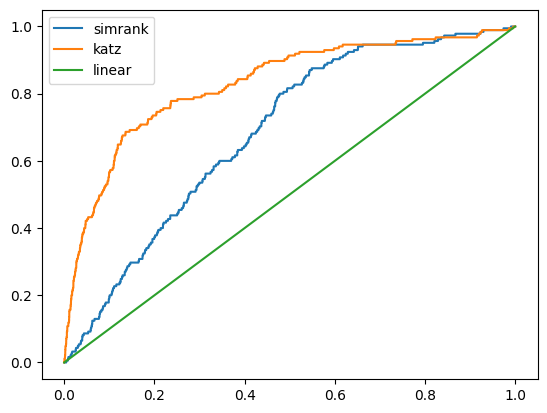

<Figure size 640x480 with 0 Axes>

In [57]:
def roc(pairs, labels):
    labels = set(labels).intersection(set(pairs))
    
    #  threshold = infinite
    tp, fp, fn, tn = 0, 0, len(labels), len(pairs) - len(labels) 
    
    fprs, tprs = [], []
    fprs.append(fp / (fp + tn + 1e-10))
    tprs.append(tp / (tp + fn + 1e-10))
    
    for pair in pairs:
        if pair in labels:
            tp += 1
            fn -= 1
        else:
            fp += 1
            tn -= 1
        fprs.append(fp / (fp + tn + 1e-10))
        tprs.append(tp / (tp + fn + 1e-10))
        
    tp, fp ,fn, tn = len(labels), len(pairs) - len(labels), 0, 0
    fprs.append(fp / (fp + tn + 1e-10))
    tprs.append(tp / (tp + fn + 1e-10))
    
    return fprs, tprs

auc_scores = {}
for key, prediction in zip(keys, predictions):
    fprs, tprs = roc(prediction, labels)
    auc_scores[key] = np.trapz(tprs, fprs)
    plt.plot(fprs, tprs, label=key)
plt.plot(np.arange(len(fprs))/len(fprs), np.arange(len(fprs))/len(fprs), label="linear")
plt.legend()
plt.show()
plt.clf()

In [58]:
pd.DataFrame(auc_scores.items(), columns=['Algorithm', 'AUC Score'])

,Algorithm,AUC Score
0,simrank,0.684596
1,katz,0.829049
